# Classification and Regression with Tensorflow

En TensorFlow, específicamente usando la API de Keras, tanto las redes neuronales secuenciales como las no secuenciales (funcionales) ofrecen maneras de definir y entrenar modelos de aprendizaje automático. Sin embargo, tienen diferencias clave en términos de flexibilidad y casos de uso.

1. **Red Neuronal Secuencial**:
   - **Estructura**: Representa un conjunto lineal de capas.
   - **Flexibilidad**: Es adecuada para redes donde una capa sigue directamente a la anterior sin bifurcaciones, saltos u otras conexiones complejas.
   - **Simplicidad**: Es más simple y directa para definir redes neuronales con una estructura simple.
   - **Uso**: Se define utilizando `Sequential()` en Keras.
   ```python
   from tensorflow.keras.models import Sequential
   from tensorflow.keras.layers import Dense

   model = Sequential()
   model.add(Dense(128, activation='relu', input_shape=(784,)))
   model.add(Dense(10, activation='softmax'))
   ```

2. **Red Neuronal Funcional (No secuencial)**:
   - **Estructura**: No tiene una estructura lineal fija, lo que permite definir modelos con múltiples entradas, múltiples salidas y compartir capas.
   - **Flexibilidad**: Es más flexible y puede representar una amplia variedad de arquitecturas, incluyendo aquellas con conexiones residuales, múltiples ramas, etc.
   - **Complejidad**: La definición puede parecer más compleja en comparación con el modelo secuencial, pero ofrece una gran potencia para definir arquitecturas personalizadas.
   - **Uso**: Se define utilizando la API funcional de Keras.
   ```python
   from tensorflow.keras.layers import Input, Dense
   from tensorflow.keras.models import Model

   inputs = Input(shape=(784,))
   x = Dense(128, activation='relu')(inputs)
   outputs = Dense(10, activation='softmax')(x)
   model = Model(inputs=inputs, outputs=outputs)
   ```

En resumen, para diseñar un modelo donde las capas siguen un flujo directo sin conexiones complicadas, la API `Sequential` es probablemente la más adecuada. Sin embargo, si el modelo tiene conexiones más complejas, múltiples entradas o salidas, o capas compartidas, la API funcional es la mejor opción. 

3. **Conjunto de entrenamiento, testeo, validación y parametros**

Al entrenar una red neuronal, es común dividir el conjunto de datos en tres subconjuntos distintos: entrenamiento, validación y prueba (o test). Cada uno de estos subconjuntos tiene un propósito específico en el proceso de entrenamiento y evaluación de la red neuronal:

**Conjunto de entrenamiento:**
El conjunto de entrenamiento es el subconjunto más grande y se utiliza para entrenar la red neuronal. La red ajusta sus parámetros y pesos en función de estos datos para aprender patrones y relaciones en los datos. Durante el entrenamiento, la red minimiza la función de pérdida al comparar sus predicciones con las etiquetas reales del conjunto de entrenamiento. El objetivo es que la red capture patrones generalizables que le permitan hacer predicciones precisas en datos nuevos.

**Conjunto de validación:**
El conjunto de validación es utilizado para ajustar hiperparámetros y evaluar el rendimiento durante el entrenamiento. Después de cada cierto número de épocas de entrenamiento, la red se evalúa en el conjunto de validación para medir su rendimiento en datos no vistos previamente. Esto ayuda a detectar el sobreajuste o subajuste y a ajustar los hiperparámetros para obtener un mejor rendimiento. El conjunto de validación se utiliza para tomar decisiones sobre la arquitectura de la red, la tasa de aprendizaje y otros parámetros.

**Conjunto de prueba (o test)**
El conjunto de prueba es un conjunto completamente independiente que la red neuronal nunca ha visto durante el entrenamiento. Se utiliza para medir el rendimiento final y la capacidad de generalización de la red neuronal. Este conjunto proporciona una evaluación objetiva y realista del rendimiento de la red en datos desconocidos. Evaluar la red en el conjunto de prueba permite determinar cómo se comporta en situaciones del mundo real y evita la posibilidad de ajustar la red específicamente para los datos de validación.

**El parámetro "batch_size"**
En una red neuronal se refiere a la cantidad de ejemplos de entrenamiento que se utilizan en cada paso de actualización de los pesos de la red durante el proceso de entrenamiento. En otras palabras, es el número de muestras que se procesan antes de que los gradientes se calculen y los pesos se ajusten mediante la optimización.

El entrenamiento de redes neuronales generalmente se realiza utilizando un método llamado descenso de gradiente estocástico (SGD, por sus siglas en inglés) o variantes más avanzadas como el descenso de gradiente mini batch. En lugar de actualizar los pesos después de cada ejemplo de entrenamiento individual (descenso de gradiente completo), se actualizan después de un conjunto de ejemplos (llamado "lote" o "batch").

El tamaño del lote (batch_size) tiene un impacto en cómo se realiza el proceso de entrenamiento y en la utilización de recursos computacionales. 

## Librerias

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
import os
from tensorflow import keras
from datetime import datetime
import sklearn
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
#import datetime

## Funciones

In [129]:
def print_model_summary(nombre_modelo, model, classificationReport, confusionMatrix):
    """    
    Funcion para los resultados del modelo de Tensorflow en un texto.
    Parameters
    ----------
    nombre_modelo : nombre que uno le da al modelo
    model : modelo de tensorflow
    classificationReport : classification report de sklearn
    confusionMatrix : confusion matrix de sklearn    
    -------
    """    
    
    f = open('results/metrics_' + nombre_modelo+ '_res.txt', 'w')
    f.write('Model: ' + nombre_modelo + '\n')
    f.write('Metrics:'+ '\n')
    f.write(str( classificationReport) + '\n')
    f.write('Confussion Matrix:'+ '\n')
    f.write( str( confusionMatrix) + '\n')
    f.write('\n')
    f.write('\n')
    f.write( str( 'Arquitectura: \n') )
    f.write('\n')
    model.summary(print_fn=lambda x: f.write(x + '\n'))    
    f.close()



def plot_metric(history, metric):
    """
    Función para graficar Accuracy en función de las Epocas para 
    conjunto de Entrenamiento y Validación 
    """
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

 
def build_model(n_hidden=1, n_output = 1, n_neurons=30,
                      input_shape=[8], activation="softmax"):
    """
    Funcion para crear un modelo de red neuronal densa de clasificación
    Parametros:
    -----------
    - n_hidden: number of hidden layers
    - n_neurons: number of neurons in each hidden layer
    - n_output: number of neurons in the output layer = number of classes    
    - activation: activation function to use for the classification (softmax for multiclass, sigmoid for binary)
    """

    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(n_output, activation=activation))

    return model

## 1) Problema de Regresión

Importamos Data 

In [130]:
petrol_cons = pd.read_csv('data\petrol_consumption.csv')
petrol_cons.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


Creamos vectores X e Y

In [131]:
X = petrol_cons.iloc[:, 0:4].values
y = petrol_cons.iloc[:, 4].values

Realizamos el split Train (80%) y Test (20%)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Se estandariza

In [133]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train) # Se almacena en SC
X_test = sc.transform(X_test)  # Utiliza distribución original
X_train[0:10]

array([[-1.32525691e-01,  1.50577399e+00,  2.25854636e+00,
        -9.15791057e-01],
       [-6.28192647e-01, -1.83367022e+00,  2.12333843e-01,
        -1.12852703e+00],
       [-1.32525691e-01, -1.78897047e+00, -4.54194551e-01,
        -5.25775100e-01],
       [-1.32525691e-01, -8.78212954e-01,  8.77245103e-01,
         4.15208375e-02],
       [-6.28192647e-01,  1.27482526e+00,  1.07480487e+00,
         2.89712810e-01],
       [ 1.35447518e+00, -8.42825648e-01, -1.13743332e+00,
         5.92488356e-02],
       [-6.28192647e-01, -4.00925436e-02, -4.64436395e-01,
         8.21552752e-01],
       [-6.28192647e-01,  7.42153173e-01,  2.93282707e-02,
         2.61208055e+00],
       [-6.28192647e-01,  8.82232011e-04,  1.22196399e+00,
         1.65616824e-01],
       [ 3.63141265e-01, -2.41241442e-01,  4.54996025e-02,
        -2.42127131e-01]])

### Arquitectura Red

In [134]:
input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(100, activation='relu')(input_layer)
dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
output = Dense(1)(dense_layer_3)

### Compilación del Modelo

In [135]:
model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [136]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_13 (Dense)            (None, 100)               500       
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dense_15 (Dense)            (None, 25)                1275      
                                                                 
 dense_16 (Dense)            (None, 1)                 26        
                                                                 
Total params: 6,851
Trainable params: 6,851
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del Modelo y Predicción

In [137]:
history = model.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.2)
pred_train = model.predict(X_train)
pred = model.predict(X_test)

Epoch 1/100
15/15 [==============================] - 1s 22ms/step - loss: 341761.7188 - mean_squared_error: 341761.7188 - val_loss: 402145.1562 - val_mean_squared_error: 402145.1562
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 341034.3750 - mean_squared_error: 341034.3750 - val_loss: 401217.6875 - val_mean_squared_error: 401217.6875
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 339859.1250 - mean_squared_error: 339859.1250 - val_loss: 399685.5625 - val_mean_squared_error: 399685.5625
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 337670.5625 - mean_squared_error: 337670.5625 - val_loss: 396687.7500 - val_mean_squared_error: 396687.7500
Epoch 5/100
15/15 [==============================] - 0s 6ms/step - loss: 333771.3438 - mean_squared_error: 333771.3438 - val_loss: 390975.6875 - val_mean_squared_error: 390975.6875
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 325889.4688 - mean_sq

15/15 [==============================] - 0s 5ms/step - loss: 3368.9270 - mean_squared_error: 3368.9270 - val_loss: 11426.5664 - val_mean_squared_error: 11426.5664
Epoch 48/100
15/15 [==============================] - 0s 5ms/step - loss: 3263.9968 - mean_squared_error: 3263.9968 - val_loss: 11507.8232 - val_mean_squared_error: 11507.8232
Epoch 49/100
15/15 [==============================] - 0s 5ms/step - loss: 3199.8347 - mean_squared_error: 3199.8347 - val_loss: 11444.1504 - val_mean_squared_error: 11444.1504
Epoch 50/100
15/15 [==============================] - 0s 5ms/step - loss: 3099.6294 - mean_squared_error: 3099.6294 - val_loss: 11349.6621 - val_mean_squared_error: 11349.6621
Epoch 51/100
15/15 [==============================] - 0s 4ms/step - loss: 2926.1223 - mean_squared_error: 2926.1223 - val_loss: 11200.4170 - val_mean_squared_error: 11200.4170
Epoch 52/100
15/15 [==============================] - 0s 5ms/step - loss: 2838.7175 - mean_squared_error: 2838.7175 - val_loss: 11145

Epoch 94/100
15/15 [==============================] - 0s 7ms/step - loss: 1619.9243 - mean_squared_error: 1619.9243 - val_loss: 10382.0137 - val_mean_squared_error: 10382.0137
Epoch 95/100
15/15 [==============================] - 0s 5ms/step - loss: 1598.1141 - mean_squared_error: 1598.1141 - val_loss: 10257.1758 - val_mean_squared_error: 10257.1758
Epoch 96/100
15/15 [==============================] - 0s 5ms/step - loss: 1581.6401 - mean_squared_error: 1581.6401 - val_loss: 10502.0469 - val_mean_squared_error: 10502.0469
Epoch 97/100
15/15 [==============================] - 0s 4ms/step - loss: 1592.7589 - mean_squared_error: 1592.7589 - val_loss: 10437.0410 - val_mean_squared_error: 10437.0410
Epoch 98/100
15/15 [==============================] - 0s 5ms/step - loss: 1561.1501 - mean_squared_error: 1561.1501 - val_loss: 10429.5410 - val_mean_squared_error: 10429.5410
Epoch 99/100
15/15 [==============================] - 0s 5ms/step - loss: 1575.4869 - mean_squared_error: 1575.4869 - va

### Resultados

Resultados en Entrenamiento

In [138]:
print(np.sqrt(mean_squared_error(y_train,pred_train)))

58.0650032228811


Resultados en Test

In [139]:
print(np.sqrt(mean_squared_error(y_test,pred)))

91.24967962375646


### Plot 

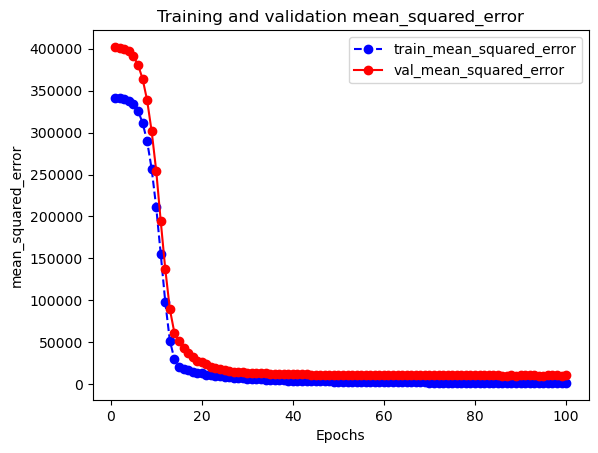

In [140]:
plot_metric(history, 'mean_squared_error')

## 2) Problema de Regresión

In [95]:
cols = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety','output']
cars = pd.read_csv('data\car_dataset.csv', names=cols, header=None)
cars

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


### Preprocesing

In [96]:
price = pd.get_dummies(cars.price, prefix='price')
maint = pd.get_dummies(cars.maint, prefix='maint')
doors = pd.get_dummies(cars.doors, prefix='doors')
persons = pd.get_dummies(cars.persons, prefix='persons')
lug_capacity = pd.get_dummies(cars.lug_capacity, prefix='lug_capacity')
safety = pd.get_dummies(cars.safety, prefix='safety')
labels = pd.get_dummies(cars.output, prefix='condition')

In [97]:
X = pd.concat([price, maint, doors, persons, lug_capacity, safety] , axis=1)
y = labels.values
X.head()

,price_high,price_low,price_med,price_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_capacity_big,lug_capacity_med,lug_capacity_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


### Split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Arquitectura

In [99]:
input_layer = Input(shape=(X.shape[1],)) 
dense_layer_1 = Dense(15, activation='relu')(input_layer)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(y.shape[1], activation='softmax')(dense_layer_2)

### Compile

In [100]:
model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_5 (Dense)             (None, 15)                330       
                                                                 
 dense_6 (Dense)             (None, 10)                160       
                                                                 
 dense_7 (Dense)             (None, 4)                 44        
                                                                 
Total params: 534
Trainable params: 534
Non-trainable params: 0
_________________________________________________________________
None


### Fit

In [20]:
history = model.fit(X_train, y_train, batch_size=8, epochs=50, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/50
139/139 [==============================] - 1s 3ms/step - loss: 1.0846 - acc: 0.6652 - val_loss: 0.9228 - val_acc: 0.6498
Epoch 2/50
139/139 [==============================] - 0s 1ms/step - loss: 0.7037 - acc: 0.7204 - val_loss: 0.7476 - val_acc: 0.6534
Epoch 3/50
139/139 [==============================] - 0s 2ms/step - loss: 0.5507 - acc: 0.7557 - val_loss: 0.6143 - val_acc: 0.7184
Epoch 4/50
139/139 [==============================] - 0s 2ms/step - loss: 0.4346 - acc: 0.8235 - val_loss: 0.5043 - val_acc: 0.8123
Epoch 5/50
139/139 [==============================] - 0s 2ms/step - loss: 0.3540 - acc: 0.8724 - val_loss: 0.4313 - val_acc: 0.8159
Epoch 6/50
139/139 [==============================] - 0s 2ms/step - loss: 0.3045 - acc: 0.8842 - val_loss: 0.3869 - val_acc: 0.8700
Epoch 7/50
139/139 [==============================] - 0s 1ms/step - loss: 0.2666 - acc: 0.8896 - val_loss: 0.3459 - val_acc: 0.8592
Epoch 8/50
139/139 [==============================] - 0s 2ms/step - loss: 0.

### Resultados

In [21]:
pred = np.argmax(model.predict(X_test), axis = 1)
y_test2= np.argmax(y_test, axis = 1)

11/11 [==============================] - 0s 1ms/step


In [22]:
print( classification_report(y_test2, pred) )
classrep = classification_report(y_test2, pred)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97        83
           1       0.69      1.00      0.81        11
           2       1.00      1.00      1.00       235
           3       1.00      0.82      0.90        17

    accuracy                           0.98       346
   macro avg       0.92      0.94      0.92       346
weighted avg       0.98      0.98      0.98       346



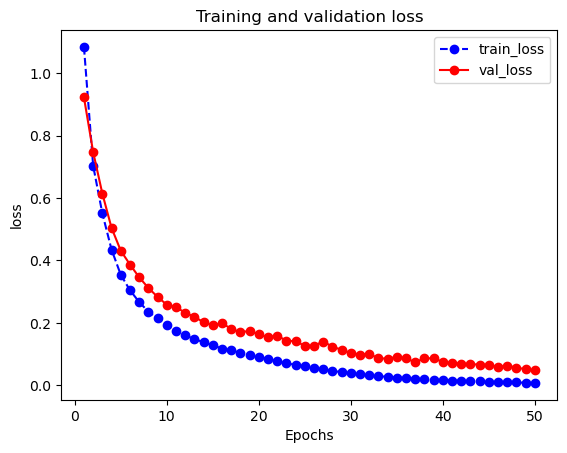

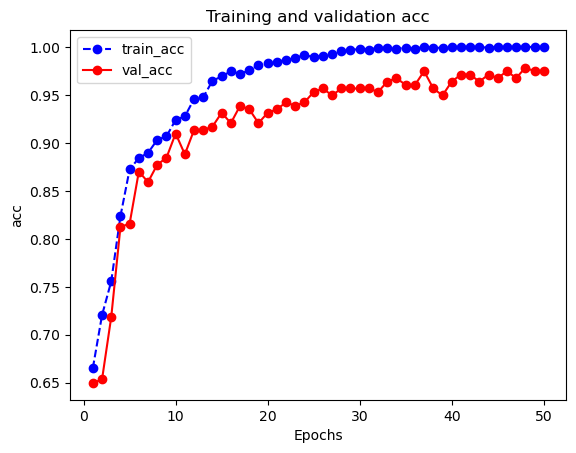

In [25]:
plot_metric(history, 'loss')
plot_metric(history, 'acc')

### 2.1) Clasification Problem with Weight Initializer and Early Stop (Callback)

### Arquitectura

In [101]:
input_layerB = Input(shape=(X.shape[1],)) 
dense_layer_1B = Dense(15, activation='relu', kernel_initializer = 'he_normal')(input_layerB)
dense_layer_2B = Dense(10, activation='relu', kernel_initializer = 'he_normal')(dense_layer_1B)
outputB = Dense(y.shape[1], activation='softmax')(dense_layer_2B)

### Compile

In [102]:
modelB = Model(inputs=input_layerB, outputs=outputB)
modelB.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(modelB.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_8 (Dense)             (None, 15)                330       
                                                                 
 dense_9 (Dense)             (None, 10)                160       
                                                                 
 dense_10 (Dense)            (None, 4)                 44        
                                                                 
Total params: 534
Trainable params: 534
Non-trainable params: 0
_________________________________________________________________
None


### Fit

In [103]:
early_stop = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
historyB = modelB.fit(X_train, y_train, batch_size=2, epochs=50, verbose=1, validation_split=0.2,callbacks = [early_stop])


Epoch 1/50
553/553 [==============================] - 2s 2ms/step - loss: 0.9286 - acc: 0.6398 - val_loss: 0.7637 - val_acc: 0.6643
Epoch 2/50
553/553 [==============================] - 1s 1ms/step - loss: 0.5324 - acc: 0.7674 - val_loss: 0.5646 - val_acc: 0.7617
Epoch 3/50
553/553 [==============================] - 1s 1ms/step - loss: 0.3637 - acc: 0.8552 - val_loss: 0.3927 - val_acc: 0.8375
Epoch 4/50
553/553 [==============================] - 1s 2ms/step - loss: 0.2611 - acc: 0.9050 - val_loss: 0.3109 - val_acc: 0.8628
Epoch 5/50
553/553 [==============================] - 1s 1ms/step - loss: 0.2164 - acc: 0.9149 - val_loss: 0.2779 - val_acc: 0.8773
Epoch 6/50
553/553 [==============================] - 1s 1ms/step - loss: 0.1861 - acc: 0.9258 - val_loss: 0.2362 - val_acc: 0.9097
Epoch 7/50
553/553 [==============================] - 1s 1ms/step - loss: 0.1636 - acc: 0.9367 - val_loss: 0.2144 - val_acc: 0.9170
Epoch 8/50
553/553 [==============================] - 1s 1ms/step - loss: 0.

### Results

11/11 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        83
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00       235
           3       1.00      0.94      0.97        17

    accuracy                           0.99       346
   macro avg       1.00      0.98      0.99       346
weighted avg       0.99      0.99      0.99       346



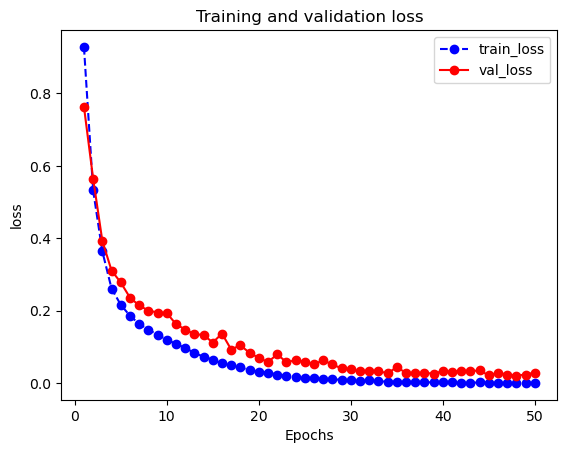

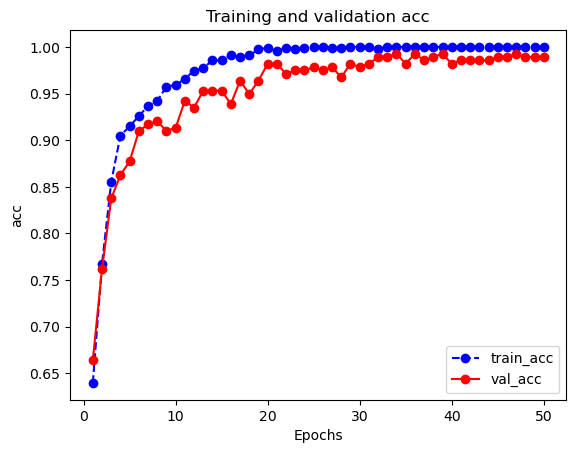

In [104]:
predB = np.argmax(modelB.predict(X_test), axis = 1)
y_test2B= np.argmax(y_test, axis = 1)


print( classification_report(y_test2B, predB) )
classrep = classification_report(y_test2B, predB)


plot_metric(historyB, 'loss')
plot_metric(historyB, 'acc')

## 2.2 Sequential Clasification Problem with Early Stop (Callback)

In [105]:
tf.keras.backend.clear_session()
model2 = keras.Sequential()

### Arquitectura Sequential

In [106]:
model2.add( keras.layers.Input(shape = X.shape[1:]))
model2.add( keras.layers.Dense(units = 700, activation = 'elu', kernel_initializer = 'he_normal'))
model2.add( keras.layers.Dense(units = 400, activation = 'elu', kernel_initializer = 'he_normal'))
model2.add( keras.layers.Dense(units = 200, activation = 'elu', kernel_initializer = 'he_normal'))
model2.add( keras.layers.Dense(units = 100, activation = 'elu', kernel_initializer = 'he_normal'))
model2.add( keras.layers.Dense(units = y.shape[1], activation = 'softmax'))

### Compile

In [107]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 700)               15400     
                                                                 
 dense_1 (Dense)             (None, 400)               280400    
                                                                 
 dense_2 (Dense)             (None, 200)               80200     
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 4)                 404       
                                                                 
Total params: 396,504
Trainable params: 396,504
Non-trainable params: 0
_________________________________________________________________


### Fit

In [108]:
early_stop = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history2 = model2.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.2,callbacks = [early_stop])

Epoch 1/100
553/553 [==============================] - 3s 5ms/step - loss: 0.4964 - acc: 0.8389 - val_loss: 0.3698 - val_acc: 0.8592
Epoch 2/100
553/553 [==============================] - 2s 4ms/step - loss: 0.2706 - acc: 0.9113 - val_loss: 0.2549 - val_acc: 0.8881
Epoch 3/100
553/553 [==============================] - 2s 4ms/step - loss: 0.1750 - acc: 0.9330 - val_loss: 0.9413 - val_acc: 0.8159
Epoch 4/100
553/553 [==============================] - 2s 4ms/step - loss: 0.1886 - acc: 0.9430 - val_loss: 0.3344 - val_acc: 0.8592
Epoch 5/100
553/553 [==============================] - 2s 4ms/step - loss: 0.1434 - acc: 0.9493 - val_loss: 0.1763 - val_acc: 0.9350
Epoch 6/100
553/553 [==============================] - 2s 4ms/step - loss: 0.1208 - acc: 0.9593 - val_loss: 0.1783 - val_acc: 0.9350
Epoch 7/100
553/553 [==============================] - 2s 4ms/step - loss: 0.0942 - acc: 0.9710 - val_loss: 0.3356 - val_acc: 0.8989
Epoch 8/100
553/553 [==============================] - 3s 5ms/step - 

### Results

In [109]:
predC = np.argmax(model2.predict(X_test), axis = 1)
y_test2C= np.argmax(y_test, axis = 1)

print( classification_report(y_test2C, predC) )
classrep = classification_report(y_test2C, predC)


11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        83
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00       235
           3       1.00      0.94      0.97        17

    accuracy                           0.99       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.99      0.99      0.99       346



In [112]:
print( confusion_matrix(y_test2C, predC))
confMat = confusion_matrix(y_test2C, predC)

name = 'Sequential_' + datetime.now().strftime('%Y%m%d_%H%M')

print_model_summary(name, model2, classrep, confMat)


[[ 82   1   0   0]
 [  0  11   0   0]
 [  0   0 235   0]
 [  1   0   0  16]]


## 2.3 Arquitectura Automatica Sequential y Tensorboard

In [38]:
tf.keras.backend.clear_session()

model3 = build_model(n_hidden = 3, n_output = y.shape[1], n_neurons=10,  input_shape=X.shape[1:])

print(model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                220       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
Total params: 484
Trainable params: 484
Non-trainable params: 0
_________________________________________________________________
None


### Compile y Callbacks

In [40]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
early_stop = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

### Crear carpeta para guardar data de Tensorboard de cada experimento, hay carpeta nueva dentro de "logs" para cada experimento 

In [49]:
folder2save = 'logs/run_' + datetime.now().strftime("%Y%m%d-%H%M")   
if not os.path.isdir(folder2save):
    os.makedirs(folder2save)
    print("created folder : ", folder2save)
tensorboad_cb = keras.callbacks.TensorBoard(log_dir = folder2save, histogram_freq=1) 

created folder :  logs/run_20230830-1627


### Fit

In [50]:
history3 = model3.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.2,callbacks = [early_stop,tensorboad_cb])


Epoch 1/100
553/553 [==============================] - 1s 2ms/step - loss: 0.0138 - acc: 0.9955 - val_loss: 0.0631 - val_acc: 0.9747
Epoch 2/100
553/553 [==============================] - 1s 2ms/step - loss: 0.0166 - acc: 0.9937 - val_loss: 0.0436 - val_acc: 0.9819
Epoch 3/100
553/553 [==============================] - 1s 2ms/step - loss: 0.0038 - acc: 0.9991 - val_loss: 0.0480 - val_acc: 0.9819
Epoch 4/100
553/553 [==============================] - 1s 2ms/step - loss: 0.0048 - acc: 0.9991 - val_loss: 0.0438 - val_acc: 0.9819
Epoch 5/100
553/553 [==============================] - 1s 2ms/step - loss: 0.0050 - acc: 0.9982 - val_loss: 0.0494 - val_acc: 0.9747
Epoch 6/100
553/553 [==============================] - 1s 2ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9819
Epoch 7/100
553/553 [==============================] - 1s 2ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0565 - val_acc: 0.9783
Epoch 8/100
553/553 [==============================] - 1s 2ms/step - 

### Results

In [51]:
pred4 = np.argmax(model3.predict(X_test), axis = 1)
y_test4= np.argmax(y_test, axis = 1)


11/11 [==============================] - 0s 1ms/step


In [52]:
print( classification_report(y_test4, pred4) )
classrep = classification_report(y_test4, pred4)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        83
           1       0.73      1.00      0.85        11
           2       1.00      1.00      1.00       235
           3       1.00      0.76      0.87        17

    accuracy                           0.98       346
   macro avg       0.93      0.93      0.92       346
weighted avg       0.98      0.98      0.98       346



In [53]:
print( confusion_matrix(y_test4, pred4))
confMat = confusion_matrix(y_test4, pred4)

[[ 80   2   1   0]
 [  0  11   0   0]
 [  0   0 235   0]
 [  2   2   0  13]]


### Load the TensorBoard notebook extension

In [55]:
%load_ext tensorboard

In [56]:
%tensorboard --logdir logs

## 2.4 MODELO FUNCIONAL

In [65]:
from tensorflow.keras import layers

tf.keras.backend.clear_session()

input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(5, activation='relu')(input_layer)
dense_layer_2 = Dense(5, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(5, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(5, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(5, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(5, activation='relu')(dense_layer_1)  #conectamos directo con la primera capa
union_layer = layers.concatenate([dense_layer_5,dense_layer_6 ])    #se unen ambas ramas
output = Dense(y.shape[1], activation='softmax')(union_layer)

model = Model(inputs=input_layer, outputs=output)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 5)            110         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 5)            30          ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 5)            30          ['dense_1[0][0]']                
                                                                                              

### Compile & Callbacks

In [66]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
early_stop = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [67]:
folder2save = 'logs/run_' + datetime.now().strftime("%Y%m%d-%H%M")   
if not os.path.isdir(folder2save):
    os.makedirs(folder2save)
    print("created folder : ", folder2save)
tensorboad_cb = keras.callbacks.TensorBoard(log_dir = folder2save, histogram_freq=1) 

created folder :  logs/run_20230830-1655


In [68]:
pred4 = np.argmax(model3.predict(X_test), axis = 1)
y_test4= np.argmax(y_test, axis = 1)

11/11 [==============================] - 0s 1ms/step


### Fit

In [69]:
history = model.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.2,callbacks = [early_stop,tensorboad_cb])

Epoch 1/100
553/553 [==============================] - 2s 2ms/step - loss: 0.8163 - acc: 0.6606 - val_loss: 0.7446 - val_acc: 0.6498
Epoch 2/100
553/553 [==============================] - 1s 2ms/step - loss: 0.4758 - acc: 0.7837 - val_loss: 0.4466 - val_acc: 0.8123
Epoch 3/100
553/553 [==============================] - 1s 2ms/step - loss: 0.3025 - acc: 0.8715 - val_loss: 0.3646 - val_acc: 0.8267
Epoch 4/100
553/553 [==============================] - 1s 2ms/step - loss: 0.2491 - acc: 0.8869 - val_loss: 0.3042 - val_acc: 0.8556
Epoch 5/100
553/553 [==============================] - 1s 2ms/step - loss: 0.2263 - acc: 0.8995 - val_loss: 0.2973 - val_acc: 0.8412
Epoch 6/100
553/553 [==============================] - 1s 2ms/step - loss: 0.2090 - acc: 0.9104 - val_loss: 0.2648 - val_acc: 0.8628
Epoch 7/100
553/553 [==============================] - 1s 2ms/step - loss: 0.1869 - acc: 0.9204 - val_loss: 0.2403 - val_acc: 0.9206
Epoch 8/100
553/553 [==============================] - 1s 2ms/step - 

553/553 [==============================] - 1s 2ms/step - loss: 0.0473 - acc: 0.9846 - val_loss: 0.1520 - val_acc: 0.9458
Epoch 63/100
553/553 [==============================] - 1s 2ms/step - loss: 0.0417 - acc: 0.9873 - val_loss: 0.1279 - val_acc: 0.9495


### Results

In [70]:
print( classification_report(y_test4, pred4) )
classrep = classification_report(y_test4, pred4)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        83
           1       0.73      1.00      0.85        11
           2       1.00      1.00      1.00       235
           3       1.00      0.76      0.87        17

    accuracy                           0.98       346
   macro avg       0.93      0.93      0.92       346
weighted avg       0.98      0.98      0.98       346



In [71]:
print( confusion_matrix(y_test4, pred4))
confMat = confusion_matrix(y_test4, pred4)

[[ 80   2   1   0]
 [  0  11   0   0]
 [  0   0 235   0]
 [  2   2   0  13]]


In [72]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7824), started 0:23:54 ago. (Use '!kill 7824' to kill it.)

## 2.5 Semilla y Batch Normalization 

In [64]:
tf.random.set_seed(42)

keras.backend.clear_session()

clf = keras.models.Sequential()
clf.add( keras.layers.Input(shape = X_train.shape[1:]))
clf.add( keras.layers.Dense(units = 8, kernel_initializer='he_normal', activation= 'elu'))
clf.add( keras.layers.BatchNormalization())
clf.add( keras.layers.Dense(units = 8, kernel_initializer='he_normal', activation= 'elu'))
clf.add( keras.layers.BatchNormalization())
clf.add( keras.layers.Dense(units = 8, kernel_initializer='he_normal', activation= 'elu'))
clf.add( keras.layers.BatchNormalization())
clf.add( keras.layers.Dense(units = 1, activation = 'sigmoid'))

clf.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = 'accuracy')

clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 176       
                                                                 
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 batch_normalization_1 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 batch_normalization_2 (Batc  (None, 8)                3

# 3.1) Clasification Problem with Mnist data set and functions

Download the FashionMNIST dataset and scale it:

In [75]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Create a very simple model:

In [76]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

Train the model using Keras and the TensorBoard callback:

In [79]:
def train_model():
  
  model = create_model()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(x=x_train, 
            y=y_train, 
            epochs=5, 
            validation_data=(x_test, y_test), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4979 - accuracy: 0.8223 - val_loss: 0.4120 - val_accuracy: 0.8511
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3820 - accuracy: 0.8597 - val_loss: 0.4412 - val_accuracy: 0.8486
Epoch 3/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3479 - accuracy: 0.8713 - val_loss: 0.3731 - val_accuracy: 0.8629
Epoch 4/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3291 - accuracy: 0.8796 - val_loss: 0.3746 - val_accuracy: 0.8647
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3124 - accuracy: 0.8838 - val_loss: 0.3557 - val_accuracy: 0.8710


In [80]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7824), started 0:42:58 ago. (Use '!kill 7824' to kill it.)